# Facial Keypoint Detection

### 1) Setup and loading data 

The first few cells are concerned with loading libraries, data sets, and setting up train/dev/test sets


In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics
from scipy.spatial import distance

import csv



In [40]:
data_directory = '../data/'
training_csv = 'training.csv'
test_csv = 'test.csv'

def space_separated_string_to_numpy_array(string):
    return np.fromstring(string, dtype=int, sep=" ")

def read_data_as_data_frame_with_image_array(data_directory, csv):
    return pd.read_csv(data_directory + csv, converters = { 
        'Image' : space_separated_string_to_numpy_array
    })

training_and_development_df = read_data_as_data_frame_with_image_array(data_directory, training_csv)
test_df = read_data_as_data_frame_with_image_array(data_directory, test_csv)
test_data = np.array([np.array(image) for image in test_df['Image'] ])
test_image_ids = np.array(test_df['ImageId'])

# The training_shuffle is used to randomly (but the same way every time) to split the data into
# training data and development data
# Set the randomizer seed so results are the same each time.
np.random.seed(0)
training_shuffle = np.random.permutation(len(training_and_development_df.index))

In [41]:
training_df = training_and_development_df[len(test_df.index):]
development_df = training_and_development_df[:len(test_df.index)]

training_df_columns = training_df.columns.values
training_df_training_columns = np.asarray([ 'Image' ])
training_df_label_columns = training_df_columns[np.where(training_df_columns != 'Image')]
def training_label_to_index(label):
    return np.where(training_df_label_columns == label)[0]
    
def index_to_training_label(index):
    return training_df_label_columns[index]

training_data = np.array([np.array(image) for image in training_df['Image'] ])
training_labels = np.array(training_df[training_df_label_columns])
development_data = np.array([np.array(image) for image in development_df['Image'] ])
development_labels = np.array(development_df[training_df_label_columns])
label_names = training_df_label_columns
x_label_indices = [ index for index, name in enumerate(label_names) if '_x' in name ]
y_label_indices = [ index for index, name in enumerate(label_names) if '_y' in name ]





## 2) A way to look at the data 

Showing an example, plotting but the labels/correct answers and predictions

In [42]:
def show_one_example(example, labels = None, predictions = None):
    matrix = np.reshape(255 - example, (96, 96))
    plt.imshow(matrix, cmap='Greys', interpolation='Nearest')
    if labels is not None:
        x_labels = labels[x_label_indices]
        y_labels = labels[y_label_indices]
        plt.scatter(x_labels, y_labels, c='g', marker = 'o')
    if predictions is not None:
        x_predictions = predictions[x_label_indices]
        y_predictions = predictions[y_label_indices]
        plt.scatter(x_predictions, y_predictions, c='r', marker='x')
    plt.tight_layout()
    plt.show()

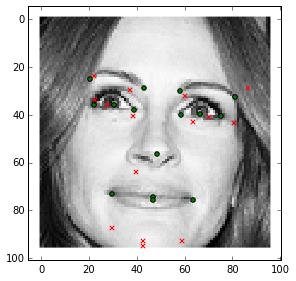

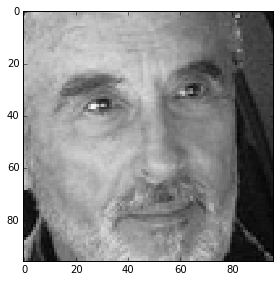

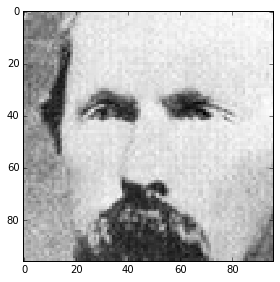

In [43]:
# intentially using the wrong predictions to show labels (green +) vs predictions (red x)

show_one_example(training_data[0], training_labels[0], training_labels[1])
show_one_example(training_data[100])
show_one_example(training_data[1000])

## 3) Computing of the error (we use pixel RMSE)

Some functions for overall fitness scoring (`development_score`) as well as for looking for errors

In [44]:
def compute_example_squared_errors(example_predicted, example_labels):
    return [ 
        (example_predicted[index] - label) ** 2
        for index, label 
        in enumerate(example_labels) 
    ]

def compute_error_squared_matrix(all_examples_predicted, all_examples_labels):
    return [
        compute_example_squared_errors(example_predicted, all_examples_labels[index])
        for index, example_predicted
        in enumerate(all_examples_predicted)
    ]

def rmse(error_matrix):
    return np.sqrt(np.nanmean(error_matrix))

def development_score(development_predictions):
    error_matrix = np.matrix(
        compute_error_squared_matrix(development_predictions, development_labels)
    )
    
    return rmse(error_matrix)

## 4) Establishing a baseline (simple mean of training algorithm)

*** Baseline development data score: 3.76889949349
*** Reference (R implementation score, some randomness): 3.758999
*** Baseline (mean coordinate) predictions on first example


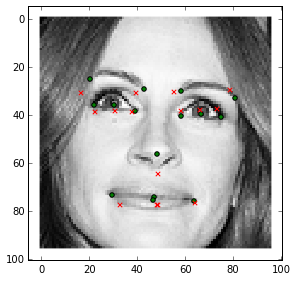

In [45]:

# Baseline - predict the mean keypoints for the training set
baseline_mean_predictions = {
        name: np.mean(
            [ 
                training_label[index] 
                for training_label 
                in training_labels 
                if training_label[index] >= 0.0
            ]
        )
        for index, name

        in enumerate(label_names)
    }

baseline_mean_predictions_array = np.array([ baseline_mean_predictions[name] for name in label_names ])

def baseline_mean_predict(example):
    return baseline_mean_predictions_array   

def baseline():
    baseline_development_predictions = [ 
        baseline_mean_predict(example) 
        for example 
        in development_data 
    ]
    
    baseline_development_score = development_score(baseline_development_predictions)
    print('*** Baseline development data score: ' + str(baseline_development_score))
    
    print('*** Reference (R implementation score, some randomness): 3.758999') 
    print('*** Baseline (mean coordinate) predictions on first example')
    
    show_one_example(training_data[0], training_labels[0], baseline_mean_predict(training_data[0]))
                     
baseline()

## 5) A very naive ML baseline - using KNearestNeighbors

We will use K nearest neighbors to predict each keypoint

In [46]:
neighbors = 5
def map_nan_to_0(value):
    if np.isnan(value):
        return 0.0
    else:
        return value
    
training_0_labels = np.array([
    map_nan_to_0(label[0])
    for label
    in training_labels
])

training_0_labels

training_labels_nansafe = np.vectorize(map_nan_to_0)(training_labels)
training_labels_nansafe

knn = KNeighborsClassifier(neighbors)
knn.fit(training_data, training_labels_nansafe)

dev_knn_predictions = knn.predict(development_data)

#training_0_labels


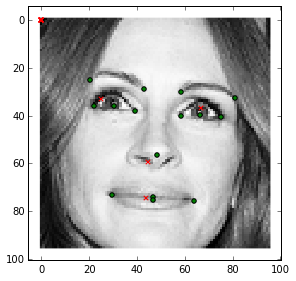

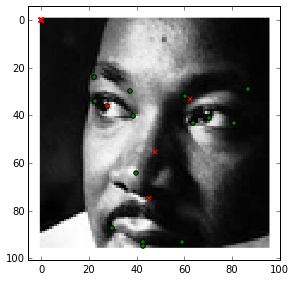

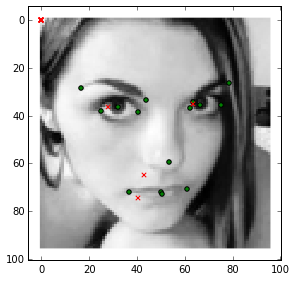

*** Score using a naive knn approach: 43.1253329178


In [51]:
show_one_example(training_data[0], training_labels[0], dev_knn_predictions[0])
show_one_example(training_data[1], training_labels[1], dev_knn_predictions[1])
show_one_example(training_data[2], training_labels[2], dev_knn_predictions[2])
print('*** Score using a naive knn approach: ' + str(development_score(dev_knn_predictions)))

In [50]:
development_score(dev_knn_predictions)

43.125332917809907

## 6) Finding 3 key regions (left eye, right eye, mouth and nose)

We will model the regions with 3 circles and transform the label set into the centers and radii of each circle
(left eye, right eye, mouth and nose)

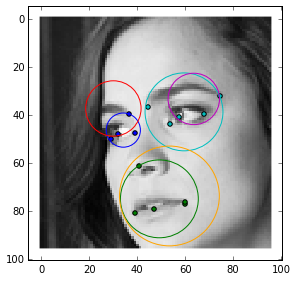

In [95]:
label_name_index = {
    name: index
    for index, name
    in enumerate(label_names)
}

def get_named_label(labels, name):
    return labels[label_name_index[name]]

def x(point):
    return point[0]

def y(point):
    return point[1]

def r(circle):
    return circle[2]

def points_to_circles(points):
    non_nan_points = [
        point
        for point 
        in points
        if (not np.isnan(x(point)) ) and (not np.isnan(y(point)))
    ]
    
    X = [ x(point) for point in non_nan_points ]
    Y = [ y(point) for point in non_nan_points ]
    
    centroid = [ np.mean(X), np.mean(Y) ]
    radius = np.max([ distance.euclidean(point, centroid) for point in non_nan_points  ])
    return [ x(centroid), y(centroid), radius ]
    
def labels_to_circles(labels):
    def value(name):
        return get_named_label(labels, name)
    
    left_eye_points = [
        [ value('left_eye_center_x'), value('left_eye_center_y') ],
        [ value('left_eye_inner_corner_x'), value('left_eye_inner_corner_y') ],
        [ value('left_eye_outer_corner_x'), value('left_eye_outer_corner_y') ],
        [ value('left_eyebrow_inner_end_x'), value('left_eyebrow_inner_end_y') ],
        [ value('left_eyebrow_outer_end_x'), value('left_eyebrow_outer_end_y') ]
    ]
    
    right_eye_points = [
        [ value('right_eye_center_x'), value('right_eye_center_y') ],
        [ value('right_eye_inner_corner_x'), value('right_eye_inner_corner_y') ],
        [ value('right_eye_outer_corner_x'), value('right_eye_outer_corner_y') ],
        [ value('right_eyebrow_inner_end_x'), value('right_eyebrow_inner_end_y') ],
        [ value('right_eyebrow_outer_end_x'), value('right_eyebrow_outer_end_y') ]
    ]
    
    mouth_and_nose_points = [
        [ value('mouth_center_bottom_lip_x'), value('mouth_center_bottom_lip_y') ],
        [ value('mouth_left_corner_x'), value('mouth_center_top_lip_y') ],
        [ value('mouth_left_corner_x'), value('mouth_left_corner_y') ],
        [ value('mouth_right_corner_x'), value('mouth_right_corner_y') ],
        [ value('nose_tip_x'), value('nose_tip_y') ]
    ]
    
    return [
        points_to_circles(left_eye_points), 
        points_to_circles(right_eye_points),
        points_to_circles(mouth_and_nose_points),
        left_eye_points,
        right_eye_points,
        mouth_and_nose_points
    ]

def show_one_example_circles(example, circle_labels = None, circle_predictions = None):
    matrix = np.reshape(255 - example, (96, 96))
    plt.imshow(matrix, cmap='Greys', interpolation='Nearest')
    
    def show_circle(circle, color, points = None, marker = None):
        circle_plt = plt.Circle(
            [ x(circle), y(circle)], 
            r(circle), 
            color=color, 
            fill=False
        )
        plt.gca().add_artist(circle_plt)
        
        if points is not None:
            X = [ x(point) for point in points ]
            Y = [ y(point) for point in points ]
            plt.scatter(X, Y, c = color, marker = marker)
        
    if circle_labels is not None:
        
        left_eye_circle = circle_labels[0]
        right_eye_circle = circle_labels[1]
        mouth_and_nose_circle = circle_labels[2]

        left_eye_points = circle_labels[3]
        right_eye_points = circle_labels[4]
        mouth_and_nose_points = circle_labels[5]
        
        show_circle(left_eye_circle, 'c', left_eye_points,  'o')
        show_circle(right_eye_circle, 'b', right_eye_points, 'o')
        show_circle(mouth_and_nose_circle, 'g',mouth_and_nose_points,  'o')

    if circle_predictions is not None:
        pred_left_eye_circle = circle_predictions[0]
        pred_right_eye_circle = circle_predictions[1]
        pred_mouth_and_nose_circle = circle_predictions[2]
        
        show_circle(pred_left_eye_circle, 'm')
        show_circle(pred_right_eye_circle, 'r')
        show_circle(pred_mouth_and_nose_circle, 'orange')
        
    plt.tight_layout()
    plt.show()

circle_labels_3 = labels_to_circles(training_labels[3])
circle_labels_4 = labels_to_circles(training_labels[4])
show_one_example_circles(training_data[3], circle_labels_3, circle_labels_4)

#label_name_index